Shape of final field: (50, 500, 500)
Shape of intensity: (50, 500, 500)


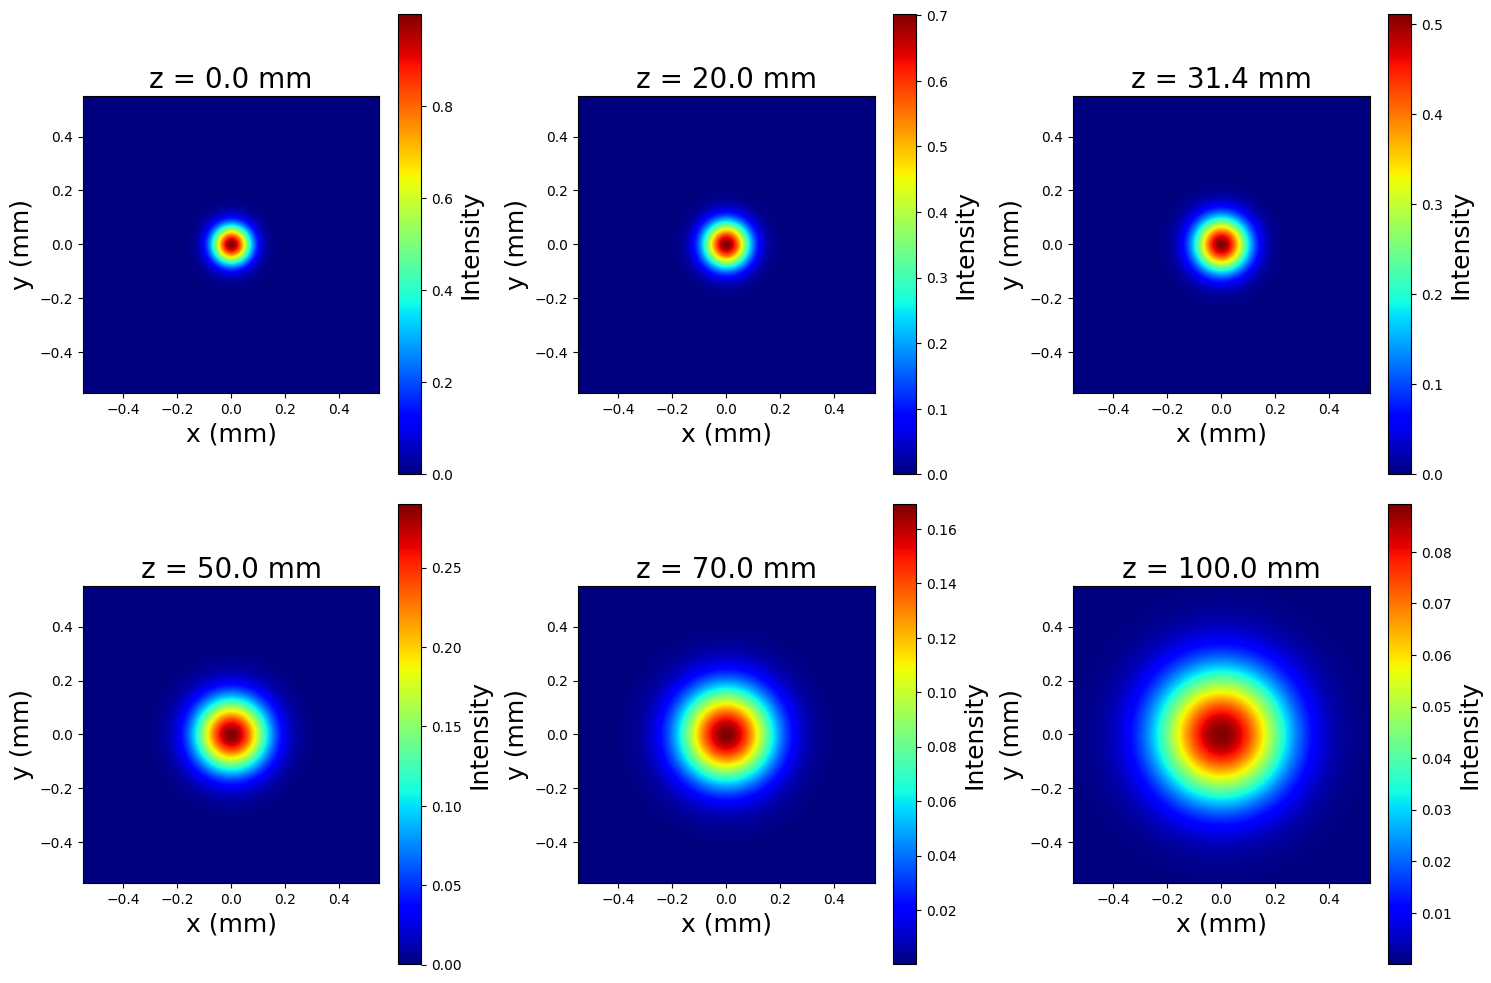

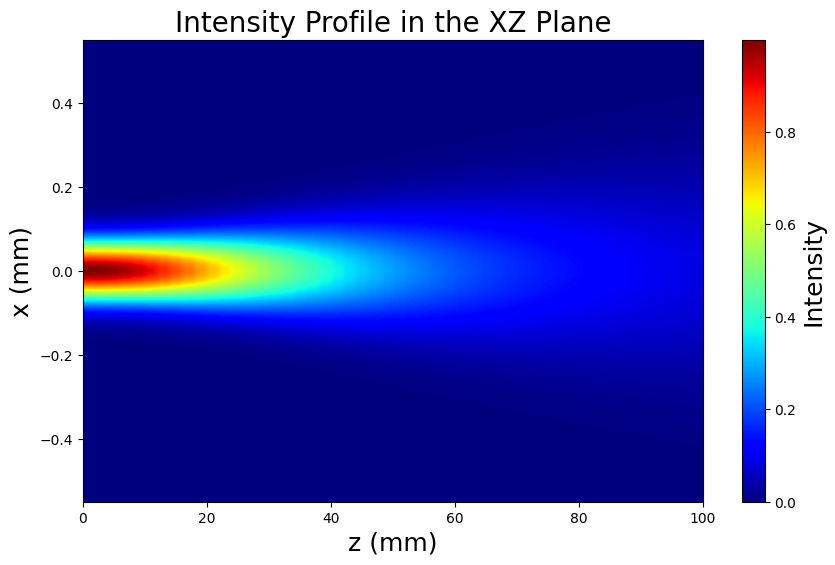

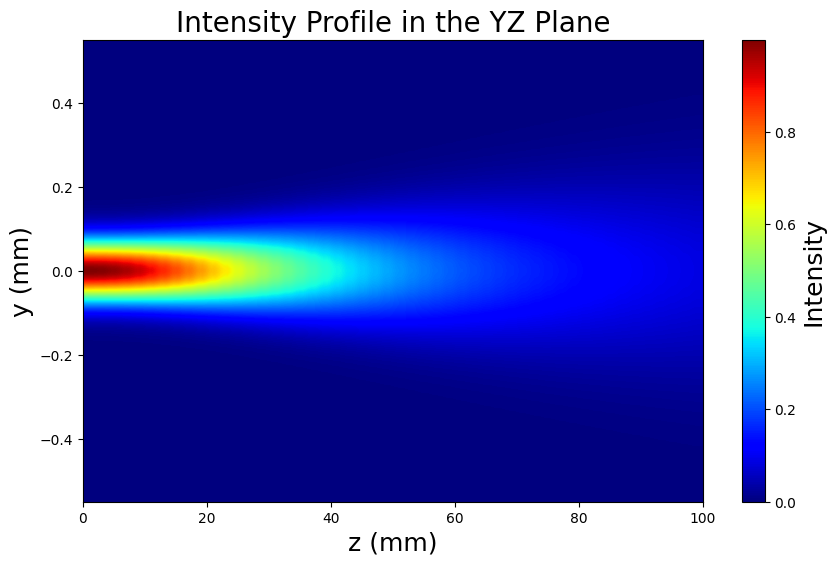

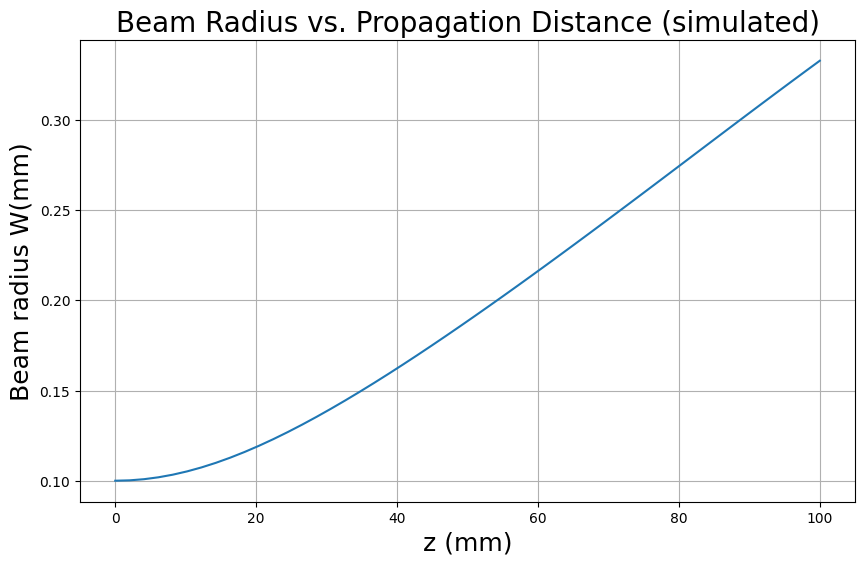

Rayleigh length =  31.415926535897935


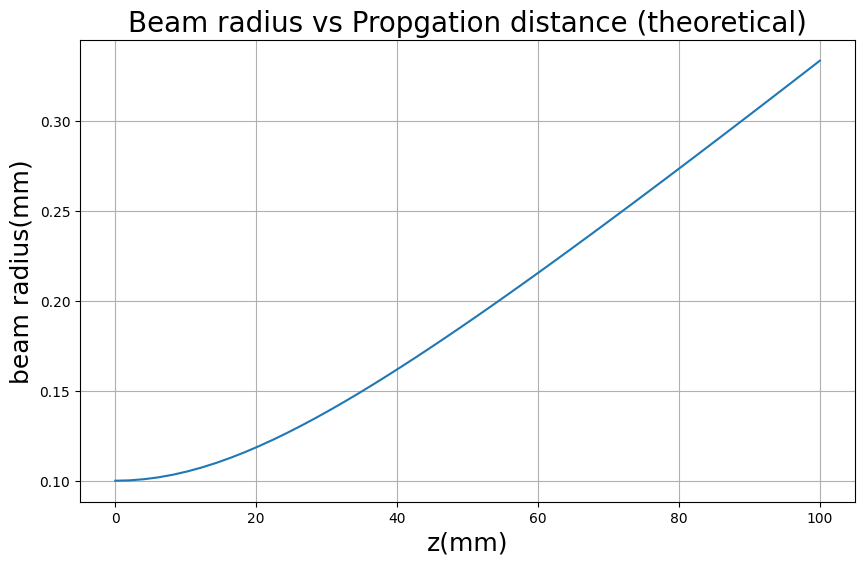

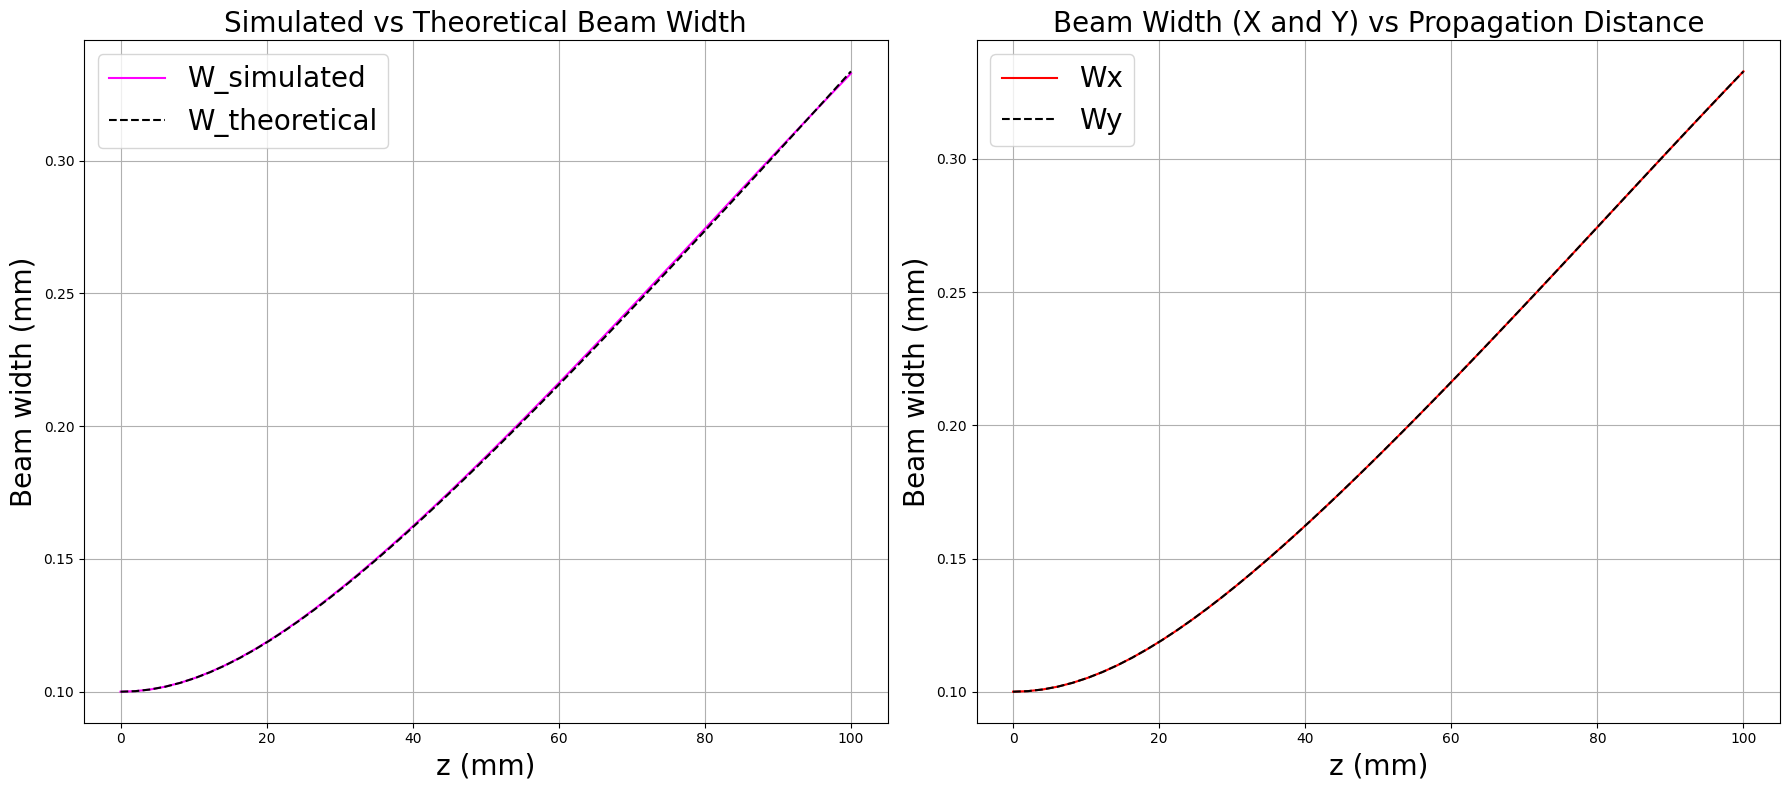

In [5]:
import numpy as np
import matplotlib.pyplot as plt


# Beam propagation using angular spectrum method
def angular_spectrum_method_with_padding(field, z_arr, wavelength, dx, dy, pad_width, alpha, bandwidth_limit=True):
    # Propagation constant
    k = 2 * np.pi / wavelength

    # Padding on input field to increase the array size
    padded_field = np.pad(field, ((pad_width, pad_width), (pad_width, pad_width)), mode='constant')

    # Creating an absorption mask
    Nx, Ny = padded_field.shape
    x = np.linspace(-1, 1, Nx)
    y = np.linspace(-1, 1, Ny)
    X, Y = np.meshgrid(x, y)
    r = np.sqrt(X**2 + Y**2)
    absorption_mask = np.exp(-alpha * np.maximum(r - 1 + 2 * pad_width / max(Nx, Ny), np.zeros_like(r))**2)

    # Applying the absorption mask
    padded_field *= absorption_mask

    # Fourier Transform of the input field
    field_ft = np.fft.fft2(padded_field)

    # Spatial frequencies
    kx = np.fft.fftfreq(Nx, dx) * 2 * np.pi
    ky = np.fft.fftfreq(Ny, dy) * 2 * np.pi
    kx, ky = np.meshgrid(kx, ky, indexing="ij")

    # Bandwidth limiting
    if bandwidth_limit:
        k_max = k
        mask = (kx**2 + ky**2 <= k_max**2)
        field_ft *= mask

    # kz in the frequency domain
    kz = np.sqrt(np.clip(k**2 - kx**2 - ky**2, 0, None))

    # Creating an empty array "propagated_fields" with the same shape of "field" array
    propagated_fields = np.empty((len(z_arr), field.shape[0], field.shape[1]), dtype=np.complex128)

    # Loop to find propagating field at each point of z
    for count, z in enumerate(z_arr):  # Looping over z
        # Propagation phase factor
        phase_factor = np.exp(1j * kz * z)

        # Propagated field in the frequency domain
        propagated_field_ft = field_ft * phase_factor

        # Inverse Fourier Transform to get the field at distance z
        propagated_field = np.fft.ifft2(propagated_field_ft)

        # Removing padding
        propagated_field = propagated_field[pad_width:Nx-pad_width, pad_width:Ny-pad_width]
        propagated_fields[count, :, :] = propagated_field

    return propagated_fields



# Parameters
wavelen = 1e-3  # Wavelength in mm
Wo = 0.1  # Beam waist in mm
p_width = 140  # Padding width
abs_coeff = 16  # Absorption coefficient

# Grid parameters
grid_size = 500
grid_extent = 1.1  # Extent of the grid in mm
delx = dely = grid_extent / grid_size

# Coordinate grid
x = np.linspace(-grid_extent / 2, grid_extent / 2, grid_size)
y = np.linspace(-grid_extent / 2, grid_extent / 2, grid_size)
X, Y = np.meshgrid(x, y)

# Initial Gaussian beam field
initial_field = np.exp(-(X**2 + Y**2) / Wo**2)

# Fixed positions on the z-axis
z_positions = np.linspace(0, 100, 50)

# Calling the function to calculate propagated fields
propag_field = angular_spectrum_method_with_padding(initial_field, z_positions, wavelen, delx, dely, p_width, abs_coeff)
print("Shape of final field:", propag_field.shape)

# Calculating intensity
intensity = np.abs(propag_field)**2
print("Shape of intensity:", intensity.shape)

# Plotting the intensity profile in XY plane at fixed z values
z_plot = np.array([0, 20, 31.4, 50, 70, 100])

plt.figure(figsize=(15, 10))
for i, z in enumerate(z_plot):
    idx = np.argmin(np.abs(z_positions - z))
    plt.subplot(2, 3, i + 1)
    img  = plt.imshow(intensity[idx], extent=[-grid_extent/2, grid_extent/2, -grid_extent/2, grid_extent/2], cmap='jet')
    cbar = plt.colorbar(img, label='Intensity')
    cbar.set_label('Intensity', fontsize=18)
    plt.title(f'z = {z} mm', fontsize=20)
    
    plt.xlabel('x (mm)', fontsize=18)
    plt.ylabel('y (mm)', fontsize=18)

plt.tight_layout()
plt.show()

# Plotting the intensity profile in the XZ plane
xz_intensity_profile = np.zeros((grid_size, len(z_positions)))

for i in range(len(z_positions)):
    xz_intensity_profile[:, i] = intensity[i, :, grid_size // 2]

plt.figure(figsize=(10, 6))
img = plt.imshow(xz_intensity_profile, extent=[0, 100, -grid_extent/2, grid_extent/2], aspect='auto', cmap='jet')
cbar = plt.colorbar(img, label='Intensity')
cbar.set_label('Intensity', fontsize=18)
plt.title('Intensity Profile in the XZ Plane', fontsize=20)

plt.xlabel('z (mm)', fontsize=18)
plt.ylabel('x (mm)', fontsize=18)
plt.show()

# Plotting the intensity profile in the YZ plane
yz_intensity_profile = np.zeros((grid_size, len(z_positions)))

for i in range(len(z_positions)):
    yz_intensity_profile[:,i] = intensity[i, grid_size//2, :]

plt.figure(figsize=(10,6))
img = plt.imshow(yz_intensity_profile, extent=[0, 100, -grid_extent/2, grid_extent/2], aspect='auto', cmap='jet')
cbar = plt.colorbar(img, label='Intensity')
cbar.set_label('Intensity', fontsize=18)
plt.title('Intensity Profile in the YZ Plane',fontsize=20)

plt.xlabel('z (mm)', fontsize=18)
plt.ylabel('y (mm)', fontsize=18)
plt.show()


def second_moment(x, y, I):
    numx = np.trapz(np.trapz(I*x**2, x, axis=0), y, axis=0)
    numy = np.trapz(np.trapz(I*y**2, y, axis=0), x, axis=0)
    den = np.trapz(np.trapz(I, y, axis=0), x, axis=0)
    return numx, numy, den

# Calculate the beam radius in x and y directions for all positions in z

Wx = np.zeros(len(z_positions))
Wy = np.zeros(len(z_positions))

for i in range(len(z_positions)):
    numx, numy, den = second_moment(x, y, intensity[i])
    Wx[i] = np.sqrt(2*numx / den)
    Wy[i] = np.sqrt(2*numy / den)

#calculation of beam width
def beam_width(Wx,Wy):
    W = np.sqrt(Wx**2 + Wy**2)
    return W

# Plotting the beam radius W along z direction
W_sim = beam_width(Wx,Wy)
plt.figure(figsize=(10,6))
plt.plot(z_positions, W_sim)
plt.xlabel('z (mm)', fontsize=18)
plt.ylabel('Beam radius W(mm)', fontsize=18)
plt.title('Beam Radius vs. Propagation Distance (simulated)', fontsize=20)
plt.grid(True)
plt.show()





#Theoretical radius
rayleigh_len = np.pi*Wo**2/wavelen  #Rayleigh length (Zr)
print('Rayleigh length = ',rayleigh_len)
W_th = np.zeros(len(z_positions))

def theor_radius(Z,Zr):
    Rad = Wo*np.sqrt(1+(Z/Zr)**2)
    return Rad

for i, z_point in enumerate(z_positions):
    W_th[i] = theor_radius(z_point,rayleigh_len)


    
# Plotting the theoretical Beam radius vs propgation distance
plt.figure(figsize=(10,6))
plt.plot(z_positions,W_th)
plt.xlabel('z(mm)', fontsize=18)
plt.ylabel('beam radius(mm)', fontsize=18)
plt.title('Beam radius vs Propgation distance (theoretical)', fontsize=20)
plt.grid(True)
plt.show()

# Subplot for Simulated vs Theoretical Beam Radius and X/Y Beam Radius

fig, ax = plt.subplots(1, 2, figsize=(18, 8))  # Create a 1x2 grid of subplots

# Plotting X and Y Beam Radii
W_x_total = beam_width(Wx, Wy)  # When plotting along x-axis, Wy=0
W_y_total = beam_width(Wx, Wy)  # When plotting along y-axis, Wx=0
ax[1].plot(z_positions, W_x_total, label='Wx', color='red')
ax[1].plot(z_positions, W_y_total, linestyle='dashed', label='Wy', color='black')
ax[1].set_xlabel('z (mm)', fontsize=20)
ax[1].set_ylabel('Beam width (mm)', fontsize=20)
ax[1].legend(fontsize=20)
ax[1].set_title('Beam Width (X and Y) vs Propagation Distance', fontsize=20)
ax[1].grid(True)

# Plotting Simulated vs Theoretical Beam Radius
ax[0].plot(z_positions, W_sim, label='W_simulated', color='magenta')
ax[0].plot(z_positions, W_th, linestyle='dashed', label='W_theoretical', color='black')
ax[0].set_xlabel('z (mm)', fontsize=20)
ax[0].set_ylabel('Beam width (mm)', fontsize=20)
ax[0].legend(fontsize=20)
ax[0].set_title('Simulated vs Theoretical Beam Width', fontsize=20)
ax[0].grid(True)

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()





